# Cell cycle model 

## Build the model by importing parameters, reactions and rate laws, and define functions that enable simulation of the cell cycle 

### hit shift+Enter to run the code below

In [2]:
using DifferentialEquations, DataFrames, Plots, CSV, Sundials, JLD2, OrdinaryDiffEq, DelimitedFiles

In [3]:
function condition(cellcycle,t,integrator) # Event when event_f(u,t) == 0
      numerator= cellcycle[indexOfRb]+cellcycle[indexOfE2FRb]+cellcycle[indexOfpE2FRb];  #ACTIVE RB
      denominator = numerator+cellcycle[indexOfHypoPRb]; #TOTAL RB

      #GM growth (biosynthesis of ribosomes and all necessary machinery)
      #previous iterations had numerator/denominator<0.8
      #diffEq.jl requires a function that hits 0
      (numerator/denominator)-0.8
end

function affect!(integrator)
  print("r31 event to 0\n")
  #update r31Switch to 0
  integrator.u[indexOfSwitch] = 0
end

function affectNeg!(integrator)
  print("r31 event to 1\n")
  #update r31Switch to 1
  integrator.u[indexOfSwitch] = 1
end

function conditionCdh(cellcycle,t,integrator) # Event when event_f(u,t) == 0

      #triggers when Cdh1 crosses 0.2 in the positive direction
      cellcycle[indexOfCdh1]-0.2
end

## all equal function
function allequal(obj)
    local x
    isfirst = true
    for i in obj
        if isfirst
            x = i
            isfirst = false
        else
            isequal(x, i) || return false
        end
    end
    return true
end

function affectCdh!(integrator)

  #triggers when Cdh1 crosses 0.2 in the positive direction
  #update Mass to 0.5* mass

#   # get mass value just before divide
#   mass_cyc = integrator.u[indexOfMass]
#   time = integrator.t
#   # push mass value to array
#   push!(mass_array, mass_cyc)
#   # push mass peak time to array
#   push!(mass_peak_time, time)
#   # if mass_array > 5, round mass values, and compare last 5
#   n=size(mass_array,1)
#   if n>6
#     mass_array_last = last(mass_array, 6)
#     mass_array_rnd = round.(mass_array_last, digits = 3)
#     if allequal(mass_array_rnd) == true
#       terminate!(integrator)
#       return(mass_array, mass_peak_time)
#     else
   integrator.u[indexOfMass] = 0.5*integrator.u[indexOfMass]
#   #Gm to 0.5 * Gm
   integrator.u[indexOfGM]=0.5*integrator.u[indexOfGM]
# end
# end
  if integrator.u[indexOfMass]<0.5
    #print("new switch 0 during division\n")
    integrator.u[indexNewSwitch]=0
  else
    #print("new switch 1 during division\n")
    integrator.u[indexNewSwitch]=1
  end
 
    #store the latest peak mass in the last spot and shuffle every entry down one.
    integrator.u[indexOfMassTracker5]=integrator.u[indexOfMassTracker4]
    integrator.u[indexOfMassTracker4]=integrator.u[indexOfMassTracker3]
    integrator.u[indexOfMassTracker3]=integrator.u[indexOfMassTracker2]
    integrator.u[indexOfMassTracker2]=integrator.u[indexOfMassTracker1]
    integrator.u[indexOfMassTracker1]=round(integrator.u[indexOfMass], digits=3)
    integrator.u[indexOfMassTrackerTime5]=integrator.u[indexOfMassTrackerTime4]
    integrator.u[indexOfMassTrackerTime4]=integrator.u[indexOfMassTrackerTime3]
    integrator.u[indexOfMassTrackerTime3]=integrator.u[indexOfMassTrackerTime2]
    integrator.u[indexOfMassTrackerTime2]=integrator.u[indexOfMassTrackerTime1]
    integrator.u[indexOfMassTrackerTime1]=integrator.t
    lastPeaks=[integrator.u[indexOfMassTracker5] integrator.u[indexOfMassTracker4] integrator.u[indexOfMassTracker3] integrator.u[indexOfMassTracker2] integrator.u[indexOfMassTracker1]]
    if allequal(lastPeaks)
        
       terminate!(integrator)
    end

 #print("division event\n")
end

## extra functions to stop the cell cycling when mass drops below 0.5

function conditionMass(cellcycle,t,integrator) # Event when event_f(u,t) == 0
      #triggers when mass crosses 0.5
      cellcycle[indexOfMass]-0.5
end

function affectMass!(integrator)
    integrator.u[indexNewSwitch] = 1
    #print("new switch 1\n")
end

function affectMassNeg!(integrator)
    integrator.u[indexNewSwitch] = 0
    #print("new switch 0\n")
end

affectMassNeg! (generic function with 1 method)

In [4]:
#use the callbacks described above to trigger events
cb = ContinuousCallback(condition,affect!,affectNeg!)
cb2 = ContinuousCallback(conditionCdh,affectCdh!,nothing)
cb3 = ContinuousCallback(conditionMass,affectMass!,affectMassNeg!)
cbs=CallbackSet(cb,cb2,cb3)

CallbackSet{Tuple{ContinuousCallback{typeof(condition), typeof(affect!), typeof(affectNeg!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}, ContinuousCallback{typeof(conditionCdh), typeof(affectCdh!), Nothing, typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}, ContinuousCallback{typeof(conditionMass), typeof(affectMass!), typeof(affectMassNeg!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}}, Tuple{}}((ContinuousCallback{typeof(condition), typeof(affect!), typeof(affectNeg!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}(condition, affect!, affectNeg!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, nothing, SciMLBase.LeftRootFind, 10, Bool[1, 1], 1, 2.220446049250313e-15, 0, 1

In [5]:
function initConditionsCellCycle(y0,syms)
   #units: M 
   y0[findfirst(isequal("ERG"),syms)]=0.0121809 
   y0[findfirst(isequal("p27_cycA_Cdk2"),syms)]=0.0356927
   y0[findfirst(isequal("p27"),syms)]=0.00922806
   y0[findfirst(isequal("Cdc20"),syms)]=0.00220177 
   y0[findfirst(isequal("p27_cycE_Cdk2"),syms)]=0.000542587
   y0[findfirst(isequal("cycE"),syms)]=0.0229112 
   y0[findfirst(isequal("cycA"),syms)]=1.4094 
   y0[findfirst(isequal("cycB"),syms)]=2.72898
   y0[findfirst(isequal("p27_cycD_Cdk2"),syms)]=0.010976 
   y0[findfirst(isequal("cycD"),syms)]=0.43929 
   y0[findfirst(isequal("Cdh1"),syms)]=0.000653278 
   y0[findfirst(isequal("DRG"),syms)]=0.900533
   y0[findfirst(isequal("PPX"),syms)]=1.0
   y0[findfirst(isequal("IEP"),syms)]=0.154655
   y0[findfirst(isequal("Cdc20t"),syms)]=2.36733
   y0[findfirst(isequal("E2F_Rb"),syms)]=0.00478911
   y0[findfirst(isequal("E2F"),syms)]=0.989986
   y0[findfirst(isequal("HypoP_Rb"),syms)]=9.97574
   y0[findfirst(isequal("pE2F_Rb"),syms)]=0.0192822
   y0[findfirst(isequal("pE2F"),syms)]=3.98594
   y0[findfirst(isequal("GM"),syms)]=1.35565
   y0[findfirst(isequal("r31switch"),syms)]=1
   y0[findfirst(isequal("cMyc"),syms)]=40
   y0[findfirst(isequal("Mass"),syms)]=1
   y0[findfirst(isequal("newSwitch"),syms)]=1
   y0[findfirst(isequal("Rb"),syms)]=0
   y0[findfirst(isequal("cMyct"),syms)]=40
   return y0
end

initConditionsCellCycle (generic function with 1 method)

### This function calculates the time point in the solution of the model at which transitions between different
### stages of the cell cycle occur.

In [6]:
### NEW FUNCTION

function Get_CC_transitions(sol_SS, time_stamp_SS)
  Cdh1_col = columnindex(sol_df, :Cdh1)
  cycA_col = columnindex(sol_df, :cycA)
  cycB_col = columnindex(sol_df, :cycB)
  cycE_col = columnindex(sol_df, :cycE)
  Mass_col = columnindex(sol_df, :Mass)

  sol_SS_cc = sol_SS[:, [Cdh1_col,cycA_col,cycB_col,cycE_col,Mass_col]]

  # G1 -> S boundary when cycB is > 0 (or close to 0)cycB_peak_df = convert_colname(max_cycB[2])
  # S to G2 when CycE is gone but before peak in CycA
  # G2 to M at peak of CycB before rapid decrease in CycB, CycA should already be decreasing and about half way gone.

  SS_zero = convert(Int64, round(time_stamp_SS[1], digits=0))

  ##G1/S
  max_Cdh1 = findmax(sol_SS_cc[:,1])
  submax_Cdh1 = (max_Cdh1[1]/100)*95
  submax_Cdh1 = findfirst(x->x>submax_Cdh1, sol_SS_cc[:,1])
  G1S_df = sol_SS_cc[submax_Cdh1:nrow(sol_SS_cc),:]
  col_Cdh1 = G1S_df[:,1]  
  half_max_Cdh1 = max_Cdh1[1]*0.5
  G1S=findfirst(x->x<half_max_Cdh1,col_Cdh1)
  G1S_t = convert(Int64, round(time_stamp_SS[G1S+submax_Cdh1],digits=0))
  G1S_t = G1S_t - SS_zero
    
  ## S/G2
  G1St = SS_zero+G1S_t
  G1St_TS = findfirst(x->x>G1St, time_stamp_SS)
  # get max value of cycA
  colcycA = sol_SS_cc[:,2]
  max_cycA = findmax(colcycA[G1St_TS:end])
  # get time when cycA is max - 2.5%
  submaxA = (max_cycA[1]/100)*97.5
  submaxA = findfirst(x->x>submaxA,colcycA)
  SG2_t = convert(Int64, round(time_stamp_SS[submaxA],digits=0))
  SG2_t = SG2_t - SS_zero

  ## G2/M
  SG2t = SS_zero+SG2_t
  SG2t_TS = findfirst(x->x>SG2t, time_stamp_SS)
  col_cycB = sol_SS_cc[:,3]
  max_cycB = findmax(col_cycB[SG2t_TS:end])
  #submaxB = (max_cycB[1]/100)*97.5
  max_cycB = findfirst(x->x==max_cycB[1],col_cycB)
  G2M_time = convert(Int64, round(time_stamp_SS[max_cycB],digits=0))
  G2M_t = G2M_time - SS_zero

  ## M
  M_t = convert(Int64, round(time_stamp_SS[end],digits=0)) - SS_zero

  return(G1S_t,SG2_t,G2M_t,M_t)

end

Get_CC_transitions (generic function with 1 method)

### Here we import csv files containing all the information required to build a model file of 
### ordinary differential equations

In [7]:
### Files
reactionsFile="reactions_plus_myc3.csv"
parametersFile="parameters_plus_myc.csv"
rateLawsFile="rateLaws_plus_myc3.csv"
arguments=[reactionsFile, parametersFile, rateLawsFile, "odeCellCycle.jl", "scan"]
locationOfCSV2Julia="csv2model-multiscale.py"
cmd=`python3 $locationOfCSV2Julia $arguments`
run(cmd)

scan
Running CSV2JuliaDiffEq with parameters left as a function call to paramFun(n), for all params. We will also create a paramFun.jl file that should be included and defines all parameters. If this is incorrect, please re-run with 5th argument set to 'inline'
Opening rateLaws_plus_myc3.csv as rate law file
Opening parameters_plus_myc.csv as parameters file
Opening reactions_plus_myc3.csv as reactions file


Process(`python3 csv2model-multiscale.py reactions_plus_myc3.csv parameters_plus_myc.csv rateLaws_plus_myc3.csv odeCellCycle.jl scan`, ProcessExited(0))

In [8]:
locationOfVariableNames="variableNames.jl"
include(locationOfVariableNames)
indexOfMass=findfirst(x->"Mass"==x,syms)
indexOfGM=findfirst(x->"GM"==x,syms)
indexNewSwitch=findfirst(x->"newSwitch"==x,syms)
indexOfRb=findfirst(x->"Rb"==x,syms)
indexOfE2FRb=findfirst(x->"E2F_Rb"==x,syms)
indexOfpE2FRb=findfirst(x->"pE2F_Rb"==x,syms)
indexOfHypoPRb=findfirst(x->"HypoP_Rb"==x,syms)
indexOfSwitch=findfirst(x->"r31switch"==x,syms)
indexOfCdh1=findfirst(x->"Cdh1"==x,syms)
indexOfMassTracker1=findfirst(x->"previousMass1"==x,syms)
indexOfMassTracker2=findfirst(x->"previousMass2"==x,syms)
indexOfMassTracker3=findfirst(x->"previousMass3"==x,syms)
indexOfMassTracker4=findfirst(x->"previousMass4"==x,syms)
indexOfMassTracker5=findfirst(x->"previousMass5"==x,syms)
indexOfMassTrackerTime1=findfirst(x->"previousMassTime1"==x,syms)
indexOfMassTrackerTime2=findfirst(x->"previousMassTime2"==x,syms)
indexOfMassTrackerTime3=findfirst(x->"previousMassTime3"==x,syms)
indexOfMassTrackerTime4=findfirst(x->"previousMassTime4"==x,syms)
indexOfMassTrackerTime5=findfirst(x->"previousMassTime5"==x,syms)

37

In [9]:
include("odeCellCycle.jl")
include("variableNames.jl")
include("scanIncludes.jl")

parameters can now be modified by name.
example to modify k_binding 1.5 fold higher:
modify["k_binding"]=1.5


### Set solve conditions

In [10]:
syms=Symbol.(syms)

maxTimeSS=100000.0
maxTimeTC=24*60.0

DISincrease=0.000001

## set time to solve
TCLength=300*60
## set max attempts to find steady state
maximumAttemptsAtSS=20

20

### Define the problem

In [11]:
f=ODEFunction(odeCellCycle,syms=syms)
y0=zeros(length(syms))
y0=initConditionsCellCycle(y0,String.(syms))
prob=ODEProblem(f,y0,(0.0,maxTimeSS))

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 100000.0)
u0: 37-element Vector{Float64}:
  0.0121809
  0.0356927
  0.00922806
  0.00220177
  0.000542587
  0.0229112
  1.4094
  2.72898
  0.010976
  0.43929
  0.000653278
  0.900533
  1.0
  ⋮
  0.0
 40.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [12]:
global colnames=["G1S", "SG2", "G2M", "M"]

4-element Vector{String}:
 "G1S"
 "SG2"
 "G2M"
 "M"

In [13]:
using JLD2, FileIO


### here we will solve the model until we find a steady state, at which point we will calculate the timing of transitions between cell cycle checkpoints

In [ ]:
paramNames = Dict("k1_16" => "ERG_deg", "k1_30" => "CycA_deg", "k1_25R" => "p27_cycE_Cdk2_deg", "k2_5" => "p27_exp", "k1_18" => "DRG_deg", "k1_12" => "Cdc20t_deg",
"k1_13" => "Cdc20_exp1", "k2_j13" => "Cdc20_exp2", "k1_14" => "Cdc20_deg1", "k2_j14" => "Cdc20_deg2",
"k1_10" => "p27_cycD_Cdk2_deg", "k2_mu" => "mass_gain", "k2_15" => "ERG_exp2", "k3_j15" => "ERG_exp3", "k2_11a" => "Cdc20t_exp2", "k3_11" => "Cdc20t_exp3", "k2_29" => "cycA_exp",
"k1_3a" => "Cdh1_exp1", "k2_3" => "Cdh1_exp2", "k3_J3" => "Cdh1_exp3", "k2_1a" => "cycB_exp2", "k3_1" => "cycB_exp3", "k4_j1" => "cycB_exp4",
"k1_23a" => "E2F_phos1", "K2_3a" => "E2F_phos2",
"k2_17" => "DRG_exp2", "k3_j17" => "DRG_exp3", "k4_17a" => "DRG_exp4", "k1_j4" => "Cdh1_deg1", "k2_4" => "Cdh1_deg2", "k3_ga" => "Cdh1_deg3", "k4_gb" => "Cdh1_deg4", "k5_ge" => "Cdh1_deg5",
"k2_1a" => "cycB_exp2", "k3_1" => "cycB_exp3", "k4_j1" => "cycB_exp4", "k2_7a" => "cycE_exp2", "k3_7" => "cycE_exp3", "k1_31" => "IEP_exp1", "k2_j31" => "IEP_exp2",
"k1_8a" => "p27.cycE.Cdk2_degp27_1", "k2_8" => "p27.cycE.Cdk2_degp27_2", "k3_yb" => "p27.cycE.Cdk2_degp27_3", "k4_ye" => "p27.cycE.Cdk2_degp27_4", "k5_j8" => "p27.cycE.Cdk2_degp27_5",
"k1_22" => "pE2F_Rb_dephos", "k1_34" => "PPX_deg",
"k1_25" => "cycAp27_bind_Cdk2", "k1_26" => "E2F_bind_Rb", "k2_23" => "E2F_phos2", "k3_2" => "cycB_deg3", "k2_2a" => "cycB_deg2", "k1_J4" => "Cdh1_deg",
"k1_24r" => "p27_cycD_Cdk2_deg",
"k2_9" => "cycD_exp", "k2_19a" => "Rb_phos2", "k4_21" => "Rb_phos4", "k5_fb" => "Rb_phos5", "k6_fe" => "Rb_phos6",
"k1_6a" => "p27.cycE/D/A.Cdk2_deg1", "k2_6" => "p27.cycE/D/A.Cdk2_deg2", "k3_ha" => "p27.cycE/D/A.Cdk2_deg3", "k4_hb" => "p27.cycE/D/A.Cdk2_deg4", "k5_he" => "p27.cycE/D/A.Cdk2_deg5",
"k1_20" => "E2F_Rb_diss1", "k2_la" => "E2F_Rb_diss2", "k3_lb" => "E2F_Rb_diss3", "k4_ld" => "E2F_Rb_diss4", "k5_le" => "E2F_Rb_diss5",
"k1_24" => "p27.cycD_binds_Cdk2", "k1_2aa" => "cycB_exp1b", "k2_j32" => "IEP_deg2", "k1_26r" => "pE2F_Rb_prod",
"k1_28" => "GM_prod", "k1_19" => "Rb_phos1", "k3_pp1t" => "Rb_phos3")

## Now we're going to run the model
### this will take a few minutes

In [14]:
### solve
println("Solving model")  
global sol = solve(prob,callback=cbs, abstol=1e-5,reltol=1e-3,saveat=1.0)
println("Model solved")

### get steady state - steady state = time between peak mass values plus division (when mass drops to zero)
sol_df = DataFrame(sol', syms)
time_stamp = sol.t
sol_df[!, :time_stamp] = time_stamp

indexOfLastCycleStart=findfirst(x->x>sol[indexOfMassTrackerTime2,end],sol.t)
sol_SS = sol_df[indexOfLastCycleStart:end, :]

# get time stamp
time_stamp_SS = sol_SS[:, :time_stamp]

### Calculate times for cell cycle transitions
colnames=["G1S", "SG2", "G2M", "M"]
plot_times = DataFrame(Array(collect(Get_CC_transitions(sol_SS, time_stamp_SS))'), colnames)
println("Plot times calculated")
println("If results look good please send beer to...")

Solving model
Model solved
Plot times calculated
If results look good please send beer to...


## Plotting

In [15]:
include(locationOfVariableNames)
global indexCdh1=findfirst(x->"Cdh1"==x,syms)
global indexMass=findfirst(x->"Mass"==x,syms)
global indexcycE=findfirst(x->"cycE"==x,syms)
global indexcycA=findfirst(x->"cycA"==x,syms)
global indexcycB=findfirst(x->"cycB"==x,syms)
global indexIEP=findfirst(x->"IEP"==x,syms)
global indexnewSwitch=findfirst(x->"newSwitch"==x,syms)
global indexmyc=findfirst(x->"cMyc"==x,syms)
global indexmyct=findfirst(x->"cMyct"==x,syms)
global indexp27=findfirst(x->"p27_cycE_Cdk2"==x,syms)
global indexcycD=findfirst(x->"cycD"==x,syms)

10

In [16]:
function plot_steady_state(sol, time_stamp_SS, title)
    G1_S = trunc(Int, (plot_times[1,1]+time_stamp_SS[1,1]))
    S_G2 = trunc(Int, (plot_times[1,2]+time_stamp_SS[1,1]))
    G2_M = trunc(Int, (plot_times[1,3]+time_stamp_SS[1,1]))
    M = trunc(Int, (plot_times[1,4]+time_stamp_SS[1,1]))

    G1S = string(plot_times[1,1])
    SG2 = string(plot_times[1,2])
    G2M = string(plot_times[1,3])
    M_ = string(plot_times[1,4])

    ###plot
    plot(sol, vars=[indexCdh1,indexcycE,indexcycA,indexcycB,indexIEP],
          lc=[:green :yellow :purple :red :blue :orange],
          lw=2.5,
          xlabel="time (hours)",
          xlims=(time_stamp_SS[1], time_stamp_SS[end]+20),
          xticks=(sol.t[indexOfLastCycleStart]:120:sol.t[end], string.(0:2:45)),
          legend= :outertopright,
          ylims=(0,5),
          title = title,
          fmt = :png)    
    vline!([G1_S], color=:black, linestyle=:dash, lw=1, label="G1/S "*G1S*" mins")
    vline!([S_G2], color=:black, linestyle=:dash, lw=1.5, label="S/G2 "*SG2*" mins")
    vline!([G2_M], color=:black, linestyle=:dash, lw=2, label="G2/M "*G2M*" mins")
    vline!([M], color=:black, linestyle=:dash, lw=2.5, label="M "*M_*" mins")
end

plot_steady_state (generic function with 1 method)

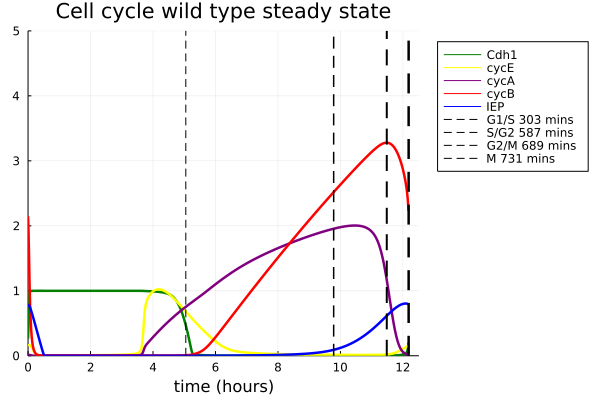

In [17]:
## plot wild type
plot_steady_state(sol, time_stamp_SS, "Cell cycle wild type steady state")

## Now that we've run the model with wild type conditions, we can see what happens if we introduce a mutation

In [31]:
function sim_mut(parameter)

    run(cmd)

    #mv("odeCellCycle.jl","odeCellCycle.jl", force=true)
    #mv("variableNames.jl","variableNames.jl", force=true)

    include("odeCellCycle.jl")
    include("variableNames.jl")
    include("scanIncludes.jl")

    modify[parameter] = 1.5

    ### solve
    println("Solving model")  
    global sol_mut = solve(prob,callback=cbs, abstol=1e-5,reltol=1e-3,saveat=1.0)
    println("Model solved")

    ### get steady state - steady state = time between peak mass values plus division (when mass drops to zero)
    sol_df = DataFrame(sol_mut', syms)
    time_stamp = sol_mut.t
    sol_df[!, :time_stamp] = time_stamp

    indexOfLastCycleStart=findfirst(x->x>sol_mut[indexOfMassTrackerTime2,end],sol_mut.t)
    sol_SS = sol_df[indexOfLastCycleStart:end, :]

    # get time stamp
    time_stamp_SS = sol_SS[:, :time_stamp]

    ### Calculate times for cell cycle transitions
    colnames=["G1S", "SG2", "G2M", "M"]
    plot_times = DataFrame(Array(collect(Get_CC_transitions(sol_SS, time_stamp_SS))'), colnames)
    println("Plot times calculated")
    println("If results look good please send beer to...")
end

sim_mut (generic function with 1 method)

In [32]:
sim_mut("k1_13")

scan
Running CSV2JuliaDiffEq with parameters left as a function call to paramFun(n), for all params. We will also create a paramFun.jl file that should be included and defines all parameters. If this is incorrect, please re-run with 5th argument set to 'inline'
Opening rateLaws_plus_myc3.csv as rate law file
Opening parameters_plus_myc.csv as parameters file
Opening reactions_plus_myc3.csv as reactions file
parameters can now be modified by name.
example to modify k_binding 1.5 fold higher:
modify["k_binding"]=1.5
Solving model
Model solved
Plot times calculated
If results look good please send beer to...


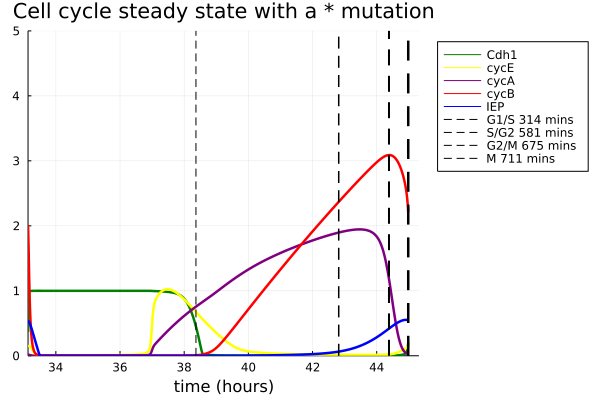

In [33]:
plot_steady_state(sol_mut, time_stamp_SS, "Cell cycle steady state with a * mutation")  ### replace the * with the name of the gene or complex mutated

## optional - if you wish to simulate different mutations of the same gene

In [ ]:
mut=[1,1.5,2,5]

In [ ]:
#### run multiple mutation simulation

function sim_mut(parameter)
    
mkpath("outputFiles/")

for (i) in mut
    
    run(cmd)
    
    mv("odeCellCycle.jl","odeCellCycle.jl", force=true)
    mv("variableNames.jl","variableNames.jl", force=true)
    
    include("odeCellCycle.jl")
    include("variableNames.jl")
    include("scanIncludes.jl")
    
    println("Solving for " ,i, "...")  
    
    modify["k1_myc"] = i
    
    global mass_array=[]
    global mass_peak_time=[]
            
     ### solve
    println("Solving model")  
    global sol = solve(prob,callback=cbs, abstol=1e-5,reltol=1e-3,saveat=1.0)
    println("Model solved")

    ### get steady state - steady state = time between peak mass values plus division (when mass drops to zero)
    global sol_df = DataFrame(sol', syms)
    global time_stamp = sol.t
    global sol_df[!, :time_stamp] = time_stamp

    indexOfLastCycleStart=findfirst(x->x>sol[indexOfMassTrackerTime2,end],sol.t)
    global sol_SS = sol_df[indexOfLastCycleStart:end, :]

    # get time stamp
    global time_stamp_SS = sol_SS[:, :time_stamp]

    ### Calculate times for cell cycle transitions
    colnames=["G1S", "SG2", "G2M", "M"]
    global plot_times = DataFrame(Array(collect(Get_CC_transitions(sol_SS, time_stamp_SS))'), colnames)
    CSV.write("outputFiles/plot_times_"*parameter*"_x"string(i)*".csv", plot_times) 
    println("Plot times calculated")
    println("If results look good please send beer to...")
        
    flush(stdout)
end

In [ ]:
## create empty DataFrame for results
plot_times_df = DataFrame(G1S=Int64[], SG2=Int64[], G2M=Int64[], M=Int64[], mut=Float64[])

In [ ]:
## find results and add to dataframe

for i in mut
    
plot_times = DataFrame(CSV.File("outputFiles/plot_times_"*string(i)*".csv", header=true))
    
plot_times[!, :mut] = [i]
    
append!(plot_times_df_myc, plot_times)
        
end

In [ ]:
# get length of each part of the cell cycle from the end times
function res_mod(df)
      for i in 1:nrow(df)
            df[i,4]=df[i,4] - df[i,3]
            df[i,3]=df[i,3] - df[i,2]
            df[i,2]=df[i,2] - df[i,1]
      end
      return(df)
end

In [ ]:
using StatsPlots

In [ ]:
function HistoPlot(plot_times)
    
    CC_res = deepcopy(plot_times[!, 1:4])
    
    CC_res = Matrix(res_mod(CC_res))
    
    G1 = CC_res[:,1]
    S = CC_res[:,2]
    G2 = CC_res[:,3]
    M = CC_res[:,4]
    
    plot_names = ["WT", "x1.5", "x2", "x5"]
    
    StatsPlots.groupedbar(plot_names, [M G2 S G1],
            bar_position = :stack,
            bar_width=0.8,
            #bar_spacing=0.5,
            label=["M" "G2" "S" "G1"],
            xlims=(0,13*60),
            xlabel="Myc copy number",
            ytickfont=font(12),
            xtickfont=font(12),
            xguidefontsize=font(12),
            orientation = :horizontal,
            #yticks=:all,
            legend=:outertopright,
            size=(1200,350)
    )
    s=string.(collect(0:1:13))
    plot!(xticks = (0:(60*1):(60*13),s),xlabel="time (hours)",fmt = :png)
    vline!([309], color=:black, linestyle=:dash, lw=1, label="G1/S WT 309 mins")
    vline!([592], color=:black, linestyle=:dash, lw=2, label="S/G2 WT 592 mins")
    vline!([688], color=:black, linestyle=:dash, lw=3, label="G2/M WT 688 mins")
    vline!([730], color=:black, linestyle=:dash, lw=4, label="M WT 730 mins")
    
end

In [ ]:
HistoPlot(plot_times_df)